### Tumor Growth Model

In [52]:
# Import needed packages
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.cm import rainbow
import numpy as np
from scipy.integrate import trapezoid
from scipy.interpolate import interp1d
from sklearn.metrics import mean_squared_error
from scipy.integrate import solve_ivp
from scipy.io import loadmat
from pysindy.utils import lorenz

import pysindy as ps

# ignore user warnings
import warnings
warnings.filterwarnings("ignore", category=UserWarning)

np.random.seed(1000)  # Seed for reproducibility

# Integrator keywords for solve_ivp
integrator_keywords = {} #initialize empty dictionary
integrator_keywords['rtol'] = 1e-16 #set 3 key-value pairs in the dictonary
integrator_keywords['method'] = 'LSODA'
integrator_keywords['atol'] = 1e-16

# bad code but allows us to ignore warnings
import warnings
from scipy.integrate.odepack import ODEintWarning
warnings.simplefilter("ignore", category=UserWarning)
warnings.simplefilter("ignore", category=FutureWarning)
warnings.simplefilter("ignore", category=ODEintWarning)

/var/folders/j4/fc2yy05n3_v93dhk228gby9h0000gn/T/ipykernel_47325/3296346913.py:29: DeprecationWarning: Please use `ODEintWarning` from the `scipy.integrate` namespace, the `scipy.integrate.odepack` namespace is deprecated.
  from scipy.integrate.odepack import ODEintWarning


In [77]:
# Define Tumor Growth Model
def tumor(t, x, c0=0.028, c1=-3.305e-6):
    return[
        c0*x[0]+c1*x[0]*x[0]
    ]

# Generate training data

dt = 1
t_train = np.arange(0, 300, dt)
t_train_span = (t_train[0], t_train[-1])
x0_train = np.array([245.185])
x_train = solve_ivp(tumor, t_train_span,
                    x0_train, t_eval=t_train, **integrator_keywords).y.T
x_dot_train_measured = np.array(
    [tumor(0, x_train[i]) for i in range(t_train.size)]
)

# Generate testing data
t_test = np.arange(0, 100, dt)
t_test_span = (t_test[0], t_test[-1])
x0_test = np.array([245.185])
x_test = solve_ivp(tumor, t_test_span, 
                   x0_test, t_eval=t_test, **integrator_keywords).y.T

In [86]:
# Fit the model

feature_names = ['x']
threshold = 1e-7 #lambda value in sparse regression optimization problem

#STLSQ: sequential threshold least square optimizer
#Using Polynomial Library (default)
model = ps.SINDy(
    feature_names = feature_names,
    optimizer=ps.STLSQ(threshold=threshold),
    feature_library=ps.PolynomialLibrary(degree=2),
)
model.fit(x_train, t=dt)
model.print()

(x)' = 0.002 1 + 0.028 x


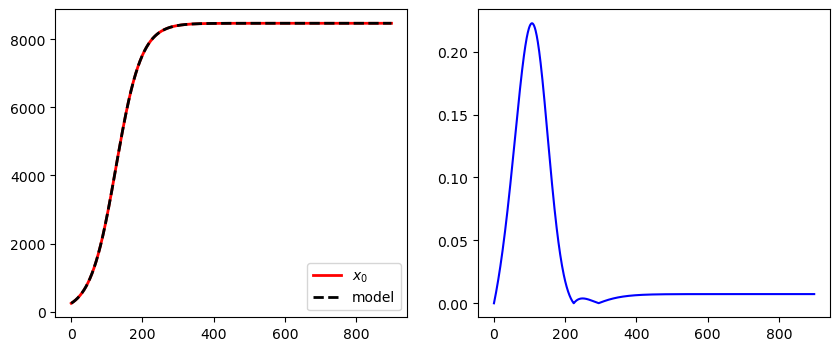

In [94]:
# Simulate and plot the results

t_sim = np.arange(0, 900, 1)
t_sim_span = (t_sim[0], t_sim[-1])
x_train = solve_ivp(tumor, t_sim_span,
                    x0_train, t_eval=t_sim, **integrator_keywords).y.T
x_sim = model.simulate(x0_train, t_sim)
plot_kws = dict(linewidth=2)

fig, axs = plt.subplots(1, 2, figsize=(10, 4))
axs[0].plot(t_sim, x_train[:, 0], "r", label="$x_0$", **plot_kws)
axs[0].plot(t_sim, x_sim[:, 0], "k--", label="model", **plot_kws)
axs[0].legend()

plt.plot(t_sim, np.abs((x_sim[:,0]-x_train[:, 0])), "b", label="error")

In [73]:
# Fit the models and simulate

poly_order = 2
threshold = 1e-7

noise_levels = [200e-4, 200e-3, 200e-2, 200e-1, 200.0]

models = []
t_sim = np.arange(0, 300, dt)
x_sim = []
for eps in noise_levels:
    model = ps.SINDy(
        optimizer=ps.STLSQ(threshold=threshold),
        feature_library=ps.PolynomialLibrary(degree=poly_order),
    )
    model.fit(
        x_train,
        t=dt,
        x_dot=x_dot_train_measured
        + np.random.normal(scale=eps, size=x_train.shape),
        quiet=True,
    )
    models.append(model)
    x_sim.append(model.simulate(x_train[0], t_sim))

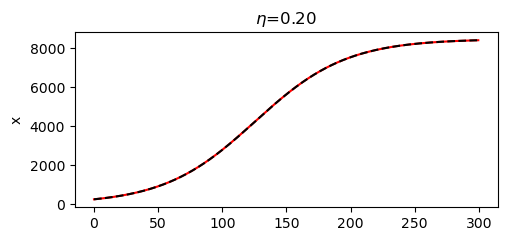

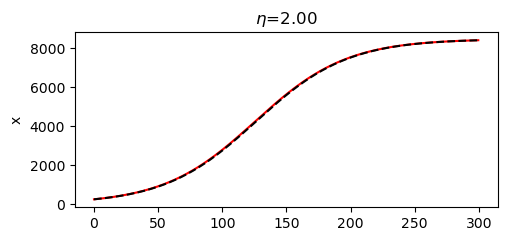

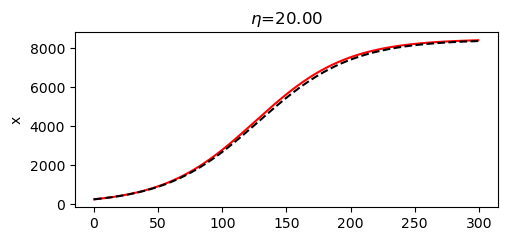

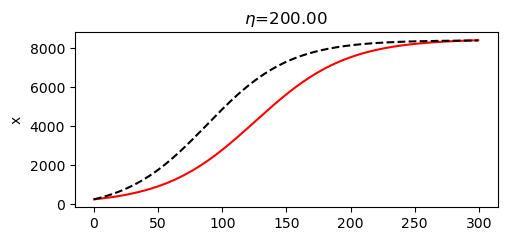

In [74]:
# Plot results

fig = plt.figure(figsize=(12, 5))
model_idx = 1
ax = fig.add_subplot(221)
ax.plot(t_sim, x_train[: t_sim.size, 0], "r")
ax.plot(t_sim, x_sim[model_idx][:, 0], "k--")
plt.title(f"$\eta$={noise_levels[model_idx]:.2f}")
plt.ylabel("x")

fig = plt.figure(figsize=(12, 5))
model_idx = 2
ax = fig.add_subplot(221)
ax.plot(t_sim, x_train[: t_sim.size, 0], "r")
ax.plot(t_sim, x_sim[model_idx][:, 0], "k--")
plt.title(f"$\eta$={noise_levels[model_idx]:.2f}")
plt.ylabel("x")

fig = plt.figure(figsize=(12, 5))
model_idx = 3
ax = fig.add_subplot(223)
ax.plot(t_sim, x_train[: t_sim.size, 0], "r")
ax.plot(t_sim, x_sim[model_idx][:, 0], "k--")
plt.title(f"$\eta$={noise_levels[model_idx]:.2f}")
plt.ylabel("x")

fig = plt.figure(figsize=(12, 5))
model_idx = 4
ax = fig.add_subplot(224)
ax.plot(t_sim, x_train[: t_sim.size, 0], "r")
ax.plot(t_sim, x_sim[model_idx][:, 0], "k--")
plt.title(f"$\eta$={noise_levels[model_idx]:.2f}")
plt.ylabel("x")


fig.show()